In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')
pd.pandas.set_option('display.max_columns',0)

In [39]:
df=pd.read_csv('yellow_tripdata_2023-01.csv',low_memory=False)

In [40]:
df.sample(3)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
860026,2,2023-01-10 19:05:18,2023-01-10 19:14:16,1.0,1.69,1.0,N,229,100,1,11.4,2.5,0.5,4.47,0.0,1.0,22.37,2.5,0.0
1042962,2,2023-01-12 16:14:40,2023-01-12 16:32:01,1.0,2.18,1.0,N,164,144,1,16.3,2.5,0.5,5.7,0.0,1.0,28.5,2.5,0.0
2825105,2,2023-01-30 08:31:24,2023-01-30 08:54:11,2.0,3.82,1.0,N,161,261,1,23.3,0.0,0.5,5.46,0.0,1.0,32.76,2.5,0.0


In [5]:
#total number of rows and column (3066812, 19)
df.shape

(3066812, 19)

In [6]:
#Check null value in all column
df.isnull().sum()

VendorID                     0
tpep_pickup_datetime         0
tpep_dropoff_datetime        0
passenger_count          71743
trip_distance                0
RatecodeID               71743
store_and_fwd_flag       71743
PULocationID                 0
DOLocationID                 0
payment_type                 0
fare_amount                  0
extra                        0
mta_tax                      0
tip_amount                   0
tolls_amount                 0
improvement_surcharge        0
total_amount                 0
congestion_surcharge     71743
airport_fee              71743
dtype: int64

In [7]:
#Check distinct value in passenger_count column
print(df['passenger_count'].isnull().sum())

71743


## passenger_count, RatecodeID, store_and_fwd_flag, congestion_surcharge and airport_fee column has 71743 records of null value.

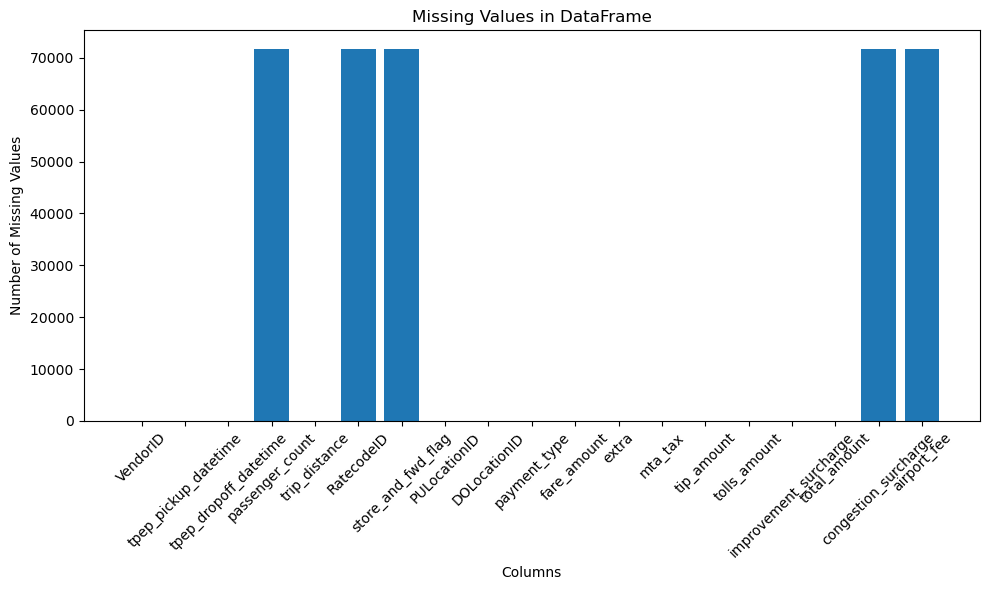

In [8]:
#Plot null value count with column

# Assuming df is your DataFrame
missing_values = df.isnull().sum()

# Creating a bar plot using Matplotlib
plt.figure(figsize=(10, 6))
plt.bar(missing_values.index, missing_values.values)
plt.title('Missing Values in DataFrame')
plt.xlabel('Columns')
plt.ylabel('Number of Missing Values')
plt.xticks(rotation=45)  # Rotating x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()


In [33]:
#Check the data types of all present column in df dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3066812 entries, 0 to 3066811
Data columns (total 19 columns):
 #   Column                 Dtype 
---  ------                 ----- 
 0   VendorID               object
 1   tpep_pickup_datetime   object
 2   tpep_dropoff_datetime  object
 3   passenger_count        object
 4   trip_distance          object
 5   RatecodeID             object
 6   store_and_fwd_flag     object
 7   PULocationID           object
 8   DOLocationID           object
 9   payment_type           object
 10  fare_amount            object
 11  extra                  object
 12  mta_tax                object
 13  tip_amount             object
 14  tolls_amount           object
 15  improvement_surcharge  object
 16  total_amount           object
 17  congestion_surcharge   object
 18  airport_fee            object
dtypes: object(19)
memory usage: 444.6+ MB


In [9]:
distinct_count = len(df['VendorID'].unique())
print("Distinct value in VendorID column",df['VendorID'].unique())
print("Count of distinct values in 'VendorID' column:", distinct_count)

Distinct value in VendorID column ['2' '1' 'VendorID']
Count of distinct values in 'VendorID' column: 3


### For data better understanding let's load the both csv file in postgresql database but this is completely optional we can do all the data preparation part using pandas.

In [41]:
import psycopg2
import pandas as pd
from psycopg2 import extras

try:
    # Establishing the connection
    conn = psycopg2.connect(
        database="postgres", user='postgres', password='password', host='127.0.0.1', port='5432')
    
    # Creating a cursor object using the cursor() method
    cursor = conn.cursor()
    
    # Create table yellow_tripdata_2023_01 if not exists
    cursor.execute('''CREATE TABLE IF NOT EXISTS yellow_tripdata_2023_01 (
                            id SERIAL PRIMARY KEY,
                            VendorID TEXT, 
                            tpep_pickup_datetime TEXT,
                            tpep_dropoff_datetime TEXT,
                            passenger_count TEXT,
                            trip_distance TEXT,
                            RatecodeID TEXT,
                            store_and_fwd_flag TEXT,
                            PULocationID TEXT,
                            DOLocationID TEXT,
                            payment_type TEXT,
                            fare_amount TEXT,
                            extra TEXT,
                            mta_tax TEXT,
                            tip_amount TEXT,
                            tolls_amount TEXT,
                            improvement_surcharge TEXT,
                            total_amount TEXT,
                            congestion_surcharge TEXT,
                            airport_fee TEXT);''')
    
    # Commit the table creation
    conn.commit()
    print("Table 'yellow_tripdata_2023_01' created successfully")
    
    # Load CSV file into a DataFrame skipping the header row
    df = pd.read_csv('yellow_tripdata_2023-01.csv', low_memory=False) 
    
    # Prepare data as a list of tuples
    data = [tuple(row) for row in df.itertuples(index=False, name=None)]
    
    # Construct the INSERT INTO statement
    insert_query = """
        INSERT INTO yellow_tripdata_2023_01 (VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, 
        trip_distance, RatecodeID, store_and_fwd_flag, PULocationID, DOLocationID, payment_type, fare_amount, extra, 
        mta_tax, tip_amount, tolls_amount, improvement_surcharge, total_amount, congestion_surcharge, airport_fee)
        VALUES %s
    """
    
    # Execute the INSERT INTO statement using execute_values()
    extras.execute_values(cursor, insert_query, data, page_size=100000) #page_size is number of rows to be inserted  
    
    # Committing the transaction
    conn.commit()
    print("Data inserted successfully in yellow_tripdata_2023_01 table")
    
    
    # Create table taxi_zones if not exists
    cursor.execute('''create table taxi_zones(OBJECTID int PRIMARY KEY,
                                                    Shape_Leng float,
                                                    the_geom text,
                                                    Shape_Area float,
                                                    Zone text,
                                                    LocationID int,
                                                    Borough text);''')
    

    # Commit the table creation
    conn.commit()
    
    print("Table 'taxi_zones' created successfully")

    # Load CSV file into a DataFrame skipping the header row
    zone_df = pd.read_csv('/home/bibek/Desktop/uber_data_engineering/data/taxi_zones.csv', low_memory=False) 
    
    # Prepare data as a list of tuples
    zone_data = [tuple(row) for row in zone_df.itertuples(index=False, name=None)]
    
    # Construct the INSERT INTO statement
    zone_insert_query = """
        INSERT INTO taxi_zones (OBJECTID,Shape_Leng,the_geom,Shape_Area,Zone,LocationID,Borough)
        VALUES %s
    """
    
    # Execute the INSERT INTO statement using execute_values()
    extras.execute_values(cursor, zone_insert_query, zone_data, page_size=1000) #page_size is number of rows to be inserted  
    
    # Committing the transaction
    conn.commit()
    print("Data inserted successfully in taxi_zones table")

except (Exception, psycopg2.Error) as error:
    print("Error while connecting to PostgreSQL or inserting data:", error)

finally:
    # Closing the connection
    if conn:
        cursor.close()
        conn.close()
        print("PostgreSQL connection is closed")

Table 'yellow_tripdata_2023_01' created successfully
Data inserted successfully in yellow_tripdata_2023_01 table
Table 'taxi_zones' created successfully
Data inserted successfully in taxi_zones table
PostgreSQL connection is closed


In [10]:
from IPython.display import Image

# Use the raw URL of the image
image_url = "https://raw.githubusercontent.com/bibek376/Uber_Data_Engineering_Project/master/pictures/1.png"

# Display the image
Image(url=image_url)


In [11]:
#only garbage data
filtered_df = df[df['VendorID'] == 'VendorID']

In [12]:
#verify them by selecting random value
filtered_df.sample(5)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
2733428,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
2600090,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
200006,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
1200041,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
1333379,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee


In [13]:
#calculate total number of garabge rows in csv file
filtered_df.shape

(46, 19)

In [14]:
#Select only the proper data
after_filtered_df=df[df['VendorID'] != 'VendorID']

#### According to data dictionary VendorID, RatecodeID, store_and_fwd_flag and payment_type are the categorical data

In [15]:
after_filtered_df['VendorID']=after_filtered_df['VendorID'].astype('category')
after_filtered_df['tpep_pickup_datetime']=pd.to_datetime(after_filtered_df['tpep_pickup_datetime'])
after_filtered_df['tpep_dropoff_datetime']=pd.to_datetime(after_filtered_df['tpep_dropoff_datetime'])
after_filtered_df['passenger_count']=pd.to_numeric(after_filtered_df['passenger_count'],downcast='integer')
after_filtered_df['trip_distance']=pd.to_numeric(after_filtered_df['trip_distance'])
after_filtered_df['RatecodeID']=after_filtered_df['RatecodeID'].astype('category')
after_filtered_df['store_and_fwd_flag']=after_filtered_df['store_and_fwd_flag'].astype('category')
after_filtered_df['PULocationID']=pd.to_numeric(after_filtered_df['PULocationID'])
after_filtered_df['DOLocationID']=pd.to_numeric(after_filtered_df['DOLocationID'])
after_filtered_df['payment_type']=after_filtered_df['payment_type'].astype('category')
after_filtered_df['fare_amount']=pd.to_numeric(after_filtered_df['fare_amount'])
after_filtered_df['extra']=pd.to_numeric(after_filtered_df['extra'])
after_filtered_df['mta_tax']=pd.to_numeric(after_filtered_df['mta_tax'])
after_filtered_df['tip_amount']=pd.to_numeric(after_filtered_df['tip_amount'])
after_filtered_df['tolls_amount']=pd.to_numeric(after_filtered_df['tolls_amount'])
after_filtered_df['improvement_surcharge']=pd.to_numeric(after_filtered_df['improvement_surcharge'])
after_filtered_df['total_amount']=pd.to_numeric(after_filtered_df['total_amount'])
after_filtered_df['congestion_surcharge']=pd.to_numeric(after_filtered_df['congestion_surcharge'])
after_filtered_df['airport_fee']=pd.to_numeric(after_filtered_df['airport_fee'])

In [16]:
#Check data type conversion
after_filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3066766 entries, 0 to 3066811
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               category      
 1   tpep_pickup_datetime   datetime64[ns]
 2   tpep_dropoff_datetime  datetime64[ns]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             category      
 6   store_and_fwd_flag     category      
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           category      
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  airport_fee            floa

### check if there is same value in tpep_pickup_datetime and tpep_dropoff_datetime: if there is same value logically data is not useful

In [17]:
same_values=after_filtered_df['tpep_pickup_datetime'] == after_filtered_df['tpep_dropoff_datetime']
same_values_df = after_filtered_df[same_values]
print("Number of rows where tpep_pickup_datetime and tpep_dropoff_datetime is same",same_values_df.shape[0])
same_values_df.sample(4)

Number of rows where tpep_pickup_datetime and tpep_dropoff_datetime is same 1118


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
1778685,1,2023-01-19 20:54:32,2023-01-19 20:54:32,1.0,0.0,1.0,N,162,264,2,7.9,3.5,0.5,0.0,0.0,1.0,12.9,2.5,0.0
718940,2,2023-01-09 10:28:48,2023-01-09 10:28:48,1.0,0.0,5.0,N,264,264,1,84.0,0.0,0.0,16.8,0.0,0.0,100.8,0.0,0.0
1104661,1,2023-01-13 07:17:48,2023-01-13 07:17:48,1.0,0.0,1.0,Y,143,264,2,3.7,2.5,0.5,0.0,0.0,1.0,7.7,2.5,0.0
1720329,1,2023-01-19 12:51:26,2023-01-19 12:51:26,1.0,0.0,1.0,N,43,264,2,3.0,2.5,0.5,0.0,0.0,1.0,7.0,2.5,0.0


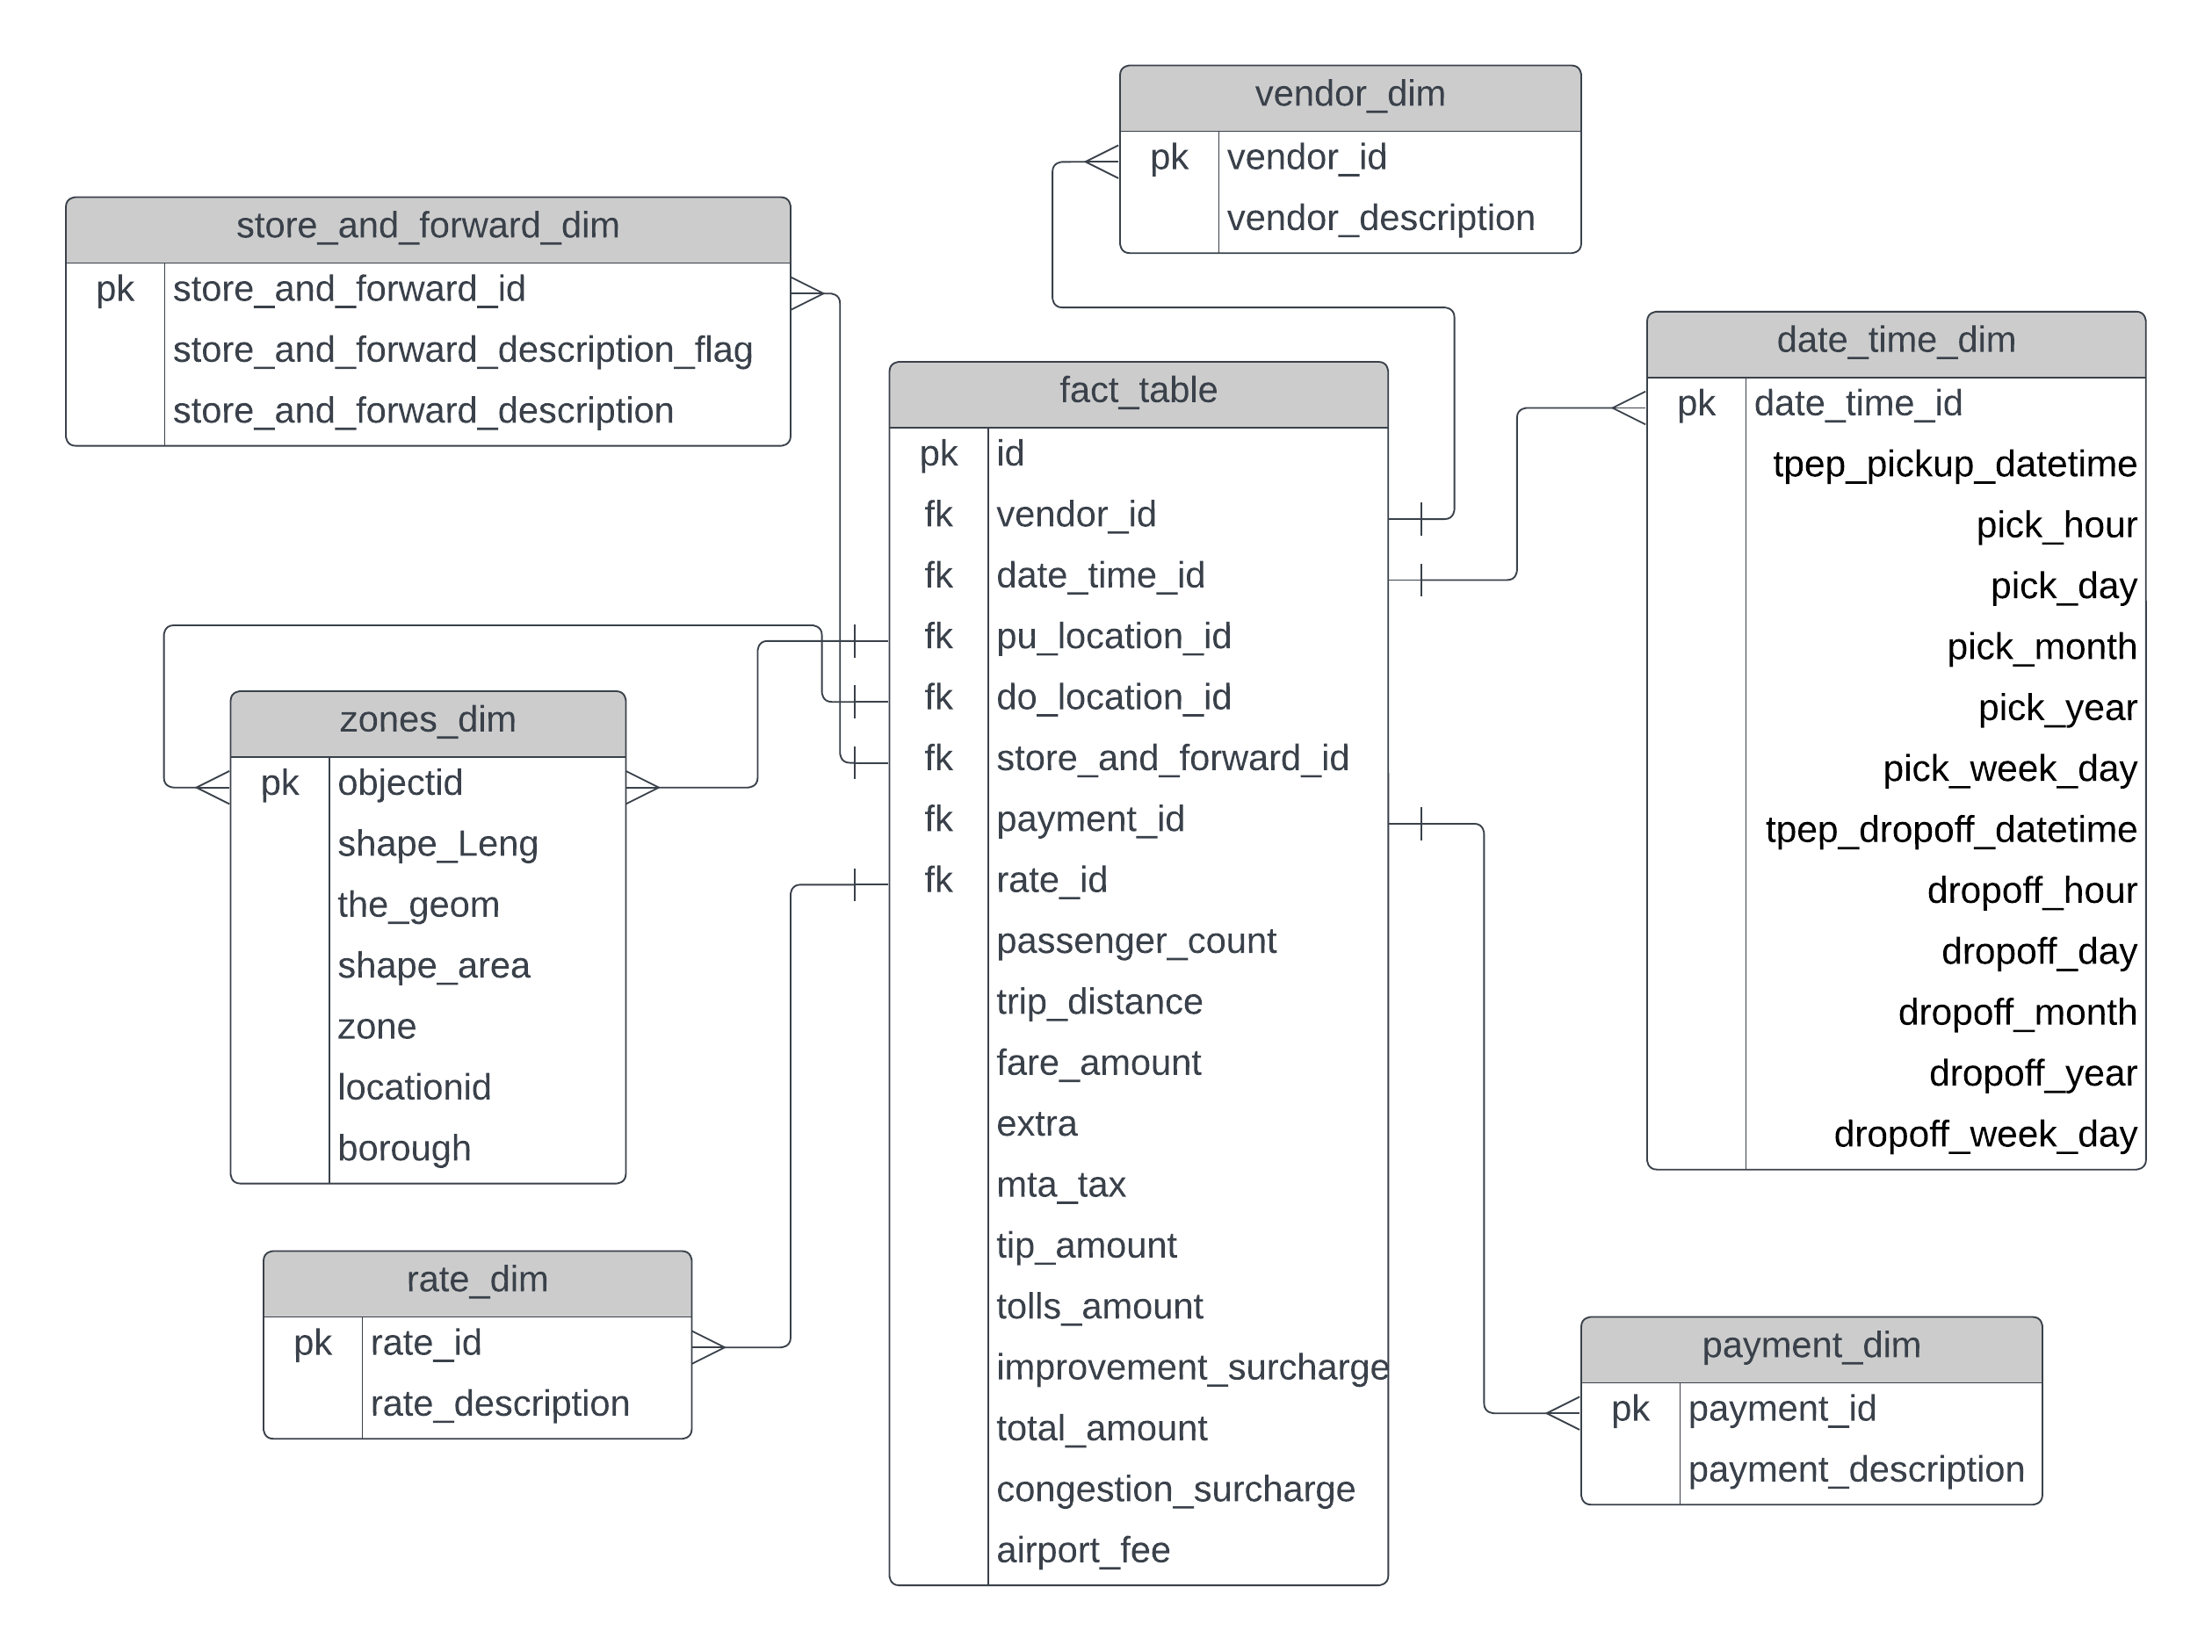

In [18]:
from IPython import display
display.Image("/home/bibek/Desktop/uber_data_engineering/pictures/2.png")

### According to ER diagram now we have to create date and time dimension table where data can be identified on the basis of month, day and year. 

In [19]:
### Extract the year, month, day, weekday and hour data using tpep_pickup_datetime and tpep_dropoff_datetime
after_filtered_df['pickup_year'] = after_filtered_df['tpep_pickup_datetime'].dt.year
after_filtered_df['pickup_month'] = after_filtered_df['tpep_pickup_datetime'].dt.month
after_filtered_df['pickup_day'] = after_filtered_df['tpep_pickup_datetime'].dt.day
after_filtered_df['pickup_weekday'] = after_filtered_df['tpep_pickup_datetime'].dt.weekday
after_filtered_df['pickup_hour'] = after_filtered_df['tpep_pickup_datetime'].dt.hour
after_filtered_df['dropoff_year'] = after_filtered_df['tpep_dropoff_datetime'].dt.year
after_filtered_df['dropoff_month'] = after_filtered_df['tpep_dropoff_datetime'].dt.month
after_filtered_df['dropoff_day'] = after_filtered_df['tpep_dropoff_datetime'].dt.day
after_filtered_df['dropoff_weekday'] = after_filtered_df['tpep_dropoff_datetime'].dt.weekday
after_filtered_df['dropoff_hour'] = after_filtered_df['tpep_dropoff_datetime'].dt.hour

In [20]:
after_filtered_df.sample(3)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,pickup_year,pickup_month,pickup_day,pickup_weekday,pickup_hour,dropoff_year,dropoff_month,dropoff_day,dropoff_weekday,dropoff_hour
201938,2,2023-01-03 18:10:58,2023-01-03 18:26:54,1.0,3.57,1.0,N,143,158,1,19.1,2.5,0.5,5.12,0.0,1.0,30.72,2.5,0.0,2023,1,3,1,18,2023,1,3,1,18
222538,1,2023-01-04 00:31:58,2023-01-04 00:47:44,1.0,2.70,1.0,N,249,232,1,17.0,3.5,0.5,4.40,0.0,1.0,26.40,2.5,0.0,2023,1,4,2,0,2023,1,4,2,0
2823499,2,2023-01-30 08:53:05,2023-01-30 09:15:04,1.0,7.18,1.0,N,237,45,1,33.1,0.0,0.5,6.50,0.0,1.0,43.60,2.5,0.0,2023,1,30,0,8,2023,1,30,0,9


In [21]:
#if tpep_pickup_datetime and tpep_dropoff_datetime is same logically it is not possible
after_duplicate_filtered_df=after_filtered_df['tpep_pickup_datetime'] != after_filtered_df['tpep_dropoff_datetime']
after_duplicate_filtered_df = after_filtered_df[after_duplicate_filtered_df]
after_duplicate_filtered_df.sample(4)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,pickup_year,pickup_month,pickup_day,pickup_weekday,pickup_hour,dropoff_year,dropoff_month,dropoff_day,dropoff_weekday,dropoff_hour
1618818,1,2023-01-18 13:10:18,2023-01-18 13:22:20,2.0,1.30,1.0,N,141,236,1,12.8,2.5,0.5,3.35,0.0,1.0,20.15,2.5,0.0,2023,1,18,2,13,2023,1,18,2,13
916340,1,2023-01-11 13:55:53,2023-01-11 14:13:49,1.0,2.60,1.0,N,141,137,2,19.1,2.5,0.5,0.00,0.0,1.0,23.10,2.5,0.0,2023,1,11,2,13,2023,1,11,2,14
2931884,2,2023-01-31 13:55:00,2023-01-31 14:01:12,2.0,0.74,1.0,N,231,231,2,7.2,0.0,0.5,0.00,0.0,1.0,11.20,2.5,0.0,2023,1,31,1,13,2023,1,31,1,14
1918955,1,2023-01-21 03:54:27,2023-01-21 03:59:17,1.0,1.10,1.0,N,263,74,2,7.9,3.5,0.5,0.00,0.0,1.0,12.90,2.5,0.0,2023,1,21,5,3,2023,1,21,5,3


In [22]:
print("Initial number of row count in yellow_tripdata_2023-01.csv file",df.shape[0], "and column is ",df.shape[1])
print("After Deleting garbage value row count is ",after_filtered_df.shape[0], 
      "and column is",after_filtered_df.shape[1])
print("Number of rows where tpep_pickup_datetime and tpep_dropoff_datetime is same",same_values_df.shape[0])
print("Number of rows after drop same value",after_duplicate_filtered_df.shape[0])

print("Number of Rows after data cleaning process",df.shape[0]-46-same_values_df.shape[0])

Initial number of row count in yellow_tripdata_2023-01.csv file 3066812 and column is  19
After Deleting garbage value row count is  3066766 and column is 29
Number of rows where tpep_pickup_datetime and tpep_dropoff_datetime is same 1118
Number of rows after drop same value 3065648
Number of Rows after data cleaning process 3065648


### let's explore taxi+_zone_lookup.csv file

In [23]:
df_taxi_zone=pd.read_csv('/home/bibek/Desktop/uber_data_engineering/data/taxi_zones.csv')
df_taxi_zone.sample(3)

,OBJECTID,Shape_Leng,the_geom,Shape_Area,zone,LocationID,borough
191,192,0.111965,MULTIPOLYGON (((-73.82239598999983 40.74986422...,0.000374,Queensboro Hill,192,Queens
199,199,0.077809,MULTIPOLYGON (((-73.88885148496313 40.79870632...,0.000289,Rikers Island,199,Bronx
250,248,0.056919,MULTIPOLYGON (((-73.8639374809998 40.840044565...,0.000150,West Farms/Bronx River,248,Bronx


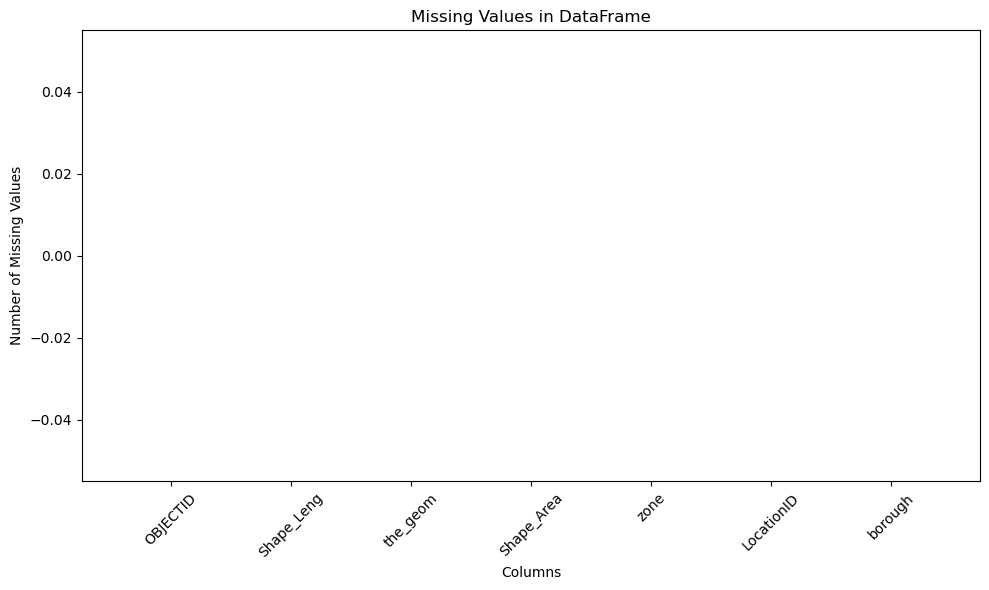

In [24]:
# Assuming df is your DataFrame
missing_values = df_taxi_zone.isnull().sum()

# Creating a bar plot using Matplotlib
plt.figure(figsize=(10, 6))
plt.bar(missing_values.index, missing_values.values)
plt.title('Missing Values in DataFrame')
plt.xlabel('Columns')
plt.ylabel('Number of Missing Values')
plt.xticks(rotation=45)  # Rotating x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

In [25]:
#dataset is fine and no need to do anything 
df_taxi_zone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 263 entries, 0 to 262
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   OBJECTID    263 non-null    int64  
 1   Shape_Leng  263 non-null    float64
 2   the_geom    263 non-null    object 
 3   Shape_Area  263 non-null    float64
 4   zone        263 non-null    object 
 5   LocationID  263 non-null    int64  
 6   borough     263 non-null    object 
dtypes: float64(2), int64(2), object(3)
memory usage: 14.5+ KB


In [26]:
after_duplicate_filtered_df.head(8).reset_index(drop=True)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,pickup_year,pickup_month,pickup_day,pickup_weekday,pickup_hour,dropoff_year,dropoff_month,dropoff_day,dropoff_weekday,dropoff_hour
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00,2023,1,1,6,0,2023,1,1,6,0
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00,2023,1,1,6,0,2023,1,1,6,1
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00,2023,1,1,6,0,2023,1,1,6,0
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25,2023,1,1,6,0,2023,1,1,6,0
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00,2023,1,1,6,0,2023,1,1,6,0
5,2,2023-01-01 00:50:34,2023-01-01 01:02:52,1.0,1.84,1.0,N,161,137,1,12.8,1.00,0.5,10.00,0.0,1.0,27.80,2.5,0.00,2023,1,1,6,0,2023,1,1,6,1
6,2,2023-01-01 00:09:22,2023-01-01 00:19:49,1.0,1.66,1.0,N,239,143,1,12.1,1.00,0.5,3.42,0.0,1.0,20.52,2.5,0.00,2023,1,1,6,0,2023,1,1,6,0
7,2,2023-01-01 00:27:12,2023-01-01 00:49:56,1.0,11.70,1.0,N,142,200,1,45.7,1.00,0.5,10.74,3.0,1.0,64.44,2.5,0.00,2023,1,1,6,0,2023,1,1,6,0


### Create all table using data warehouse ER diagram

In [27]:
#prepare data for date_time_dim table
date_time_dim=after_duplicate_filtered_df[['tpep_pickup_datetime','pickup_year','pickup_month',
               'pickup_day','pickup_weekday','pickup_hour','tpep_dropoff_datetime',
              'dropoff_year','dropoff_month','dropoff_day','dropoff_weekday','dropoff_hour']]

In [28]:
date_time_dim.sample(2).reset_index(drop=True)

,tpep_pickup_datetime,pickup_year,pickup_month,pickup_day,pickup_weekday,pickup_hour,tpep_dropoff_datetime,dropoff_year,dropoff_month,dropoff_day,dropoff_weekday,dropoff_hour
0,2023-01-03 15:56:40,2023,1,3,1,15,2023-01-03 16:04:55,2023,1,3,1,16
1,2023-01-25 18:24:35,2023,1,25,2,18,2023-01-25 18:28:31,2023,1,25,2,18


### VendorID - A code indicating the TPEP provider that provided the record.
#### 1= Creative Mobile Technologies, LLC; 2= VeriFone Inc.

In [29]:
# #prepare data for vendor_dim table
# vendor_mode={
#     1:"Creative Mobile Technologies, LLC",
#     2:"VeriFone Inc."
# }
# after_duplicate_filtered_df['vendor_description']=after_duplicate_filtered_df['VendorID'].map(vendor_mode)
# vendor_dim=after_duplicate_filtered_df[['VendorID','vendor_description']]

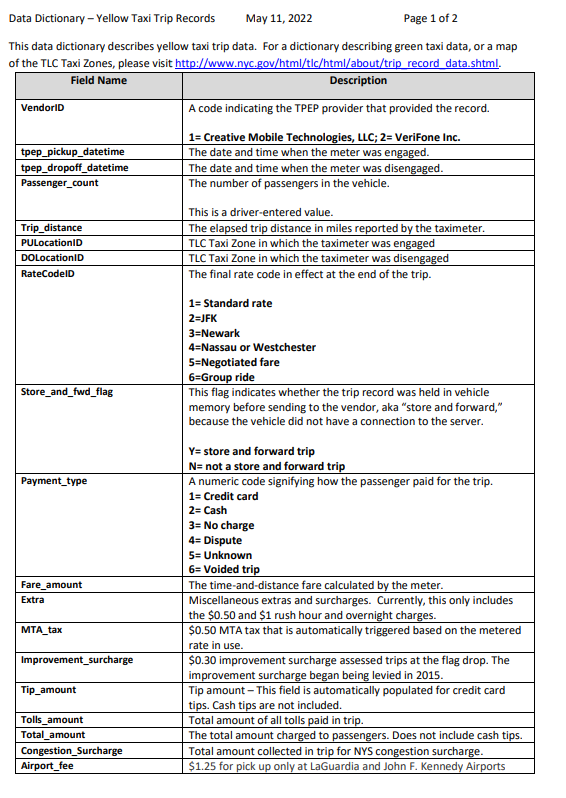

In [30]:
from IPython import display
display.Image("/home/bibek/Desktop/uber_data_engineering/pictures/3.png")

### According to data dictionary VendorId, RateCodeId, Store_and_fwd_flag and payment_type column have categorical data and can be seprate tables base on this.

In [42]:
import psycopg2
import pandas as pd
from psycopg2 import extras

try:
    # Establishing the connection
    conn = psycopg2.connect(
        database="postgres", user='postgres', password='password', host='127.0.0.1', port='5432')
    
    # Creating a cursor object using the cursor() method
    cursor = conn.cursor()
    
    # Create table vendor_dim if not exists
    cursor.execute('''CREATE TABLE IF NOT EXISTS vendor_dim (
                            vendor_id INT PRIMARY KEY,
                            vendor_description varchar(200));''')
    
    # Commit the table creation
    conn.commit()
    
    print("Table 'vendor_dim' created successfully")
    
    # Construct the INSERT INTO statement
    insert_query = """
        INSERT INTO vendor_dim (vendor_id, vendor_description)
        VALUES (%s,%s) 
    """
    record_to_insert=([(1,'Creative Mobile Technologies, LLC'),(2,'VeriFone Inc.')])

    cursor.executemany(insert_query, record_to_insert)
    
    # Committing the transaction
    conn.commit()
    
    print("Data inserted successfully in vendor_dim table")

    # Create table payment_dim if not exists
    cursor.execute('''CREATE TABLE IF NOT EXISTS payment_dim (
                            payment_id INT PRIMARY KEY,
                            payment_description varchar(200));''')
    
    # Commit the table creation
    conn.commit()
    
    print("Table 'payment_dim' created successfully")
    
    # Construct the INSERT INTO statement
    insert_query = """
        INSERT INTO payment_dim (payment_id, payment_description)
        VALUES (%s,%s)
    """
    record_to_insert=([(1,'Credit card'),(2,'Cash'),(3,'No charge'),(4,'Dispute'),(5,'Unknown'),(6,'Voided trip')])
    
    cursor.executemany(insert_query, record_to_insert)

    # Committing the transaction
    conn.commit()
    
    print("Data inserted successfully in payment_dim table")


    # Create table rate_dim if not exists
    cursor.execute('''CREATE TABLE IF NOT EXISTS rate_dim (
                            rate_id INT PRIMARY KEY,
                            rate_description varchar(200));''')
    
    # Commit the table creation
    conn.commit()
    
    print("Table 'rate_dim' created successfully")
    
    # Construct the INSERT INTO statement
    insert_query = """
        INSERT INTO rate_dim (rate_id, rate_description)
        VALUES (%s,%s)
    """
    record_to_insert=([(1,'Standard rate'),(2,'JFK'),
        (3,'Newark'),(4,'Nassau or Westchester'),(5,'Negotiated fare'),
        (6,'Group ride')])
    
    cursor.executemany(insert_query, record_to_insert)
    
    # Committing the transaction
    conn.commit()
    
    print("Data inserted successfully in rate_dim table")
    

#     To store geo data first we have to install postgis package in os and extension in
#     in database
    
    cursor.execute('''CREATE EXTENSION IF NOT EXISTS postgis;''')
    
        
#     Create table zones_dim if not exists
    cursor.execute('''create table zones_dim(objectid int PRIMARY KEY,
                                                    shape_leng float,
                                                    the_geom GEOMETRY(MultiPolygon, 4326),
                                                    shape_area float,
                                                    zone varchar(200),
                                                    locationid int,
                                                    borough varchar(200));''')
    

    # Commit the table creation
    conn.commit()
    
    print("Table 'zones_dim' created successfully")

    # Load CSV file into a DataFrame skipping the header row
    zone_df = pd.read_csv('/home/bibek/Desktop/uber_data_engineering/data/taxi_zones.csv', low_memory=False) 
    
    # Prepare data as a list of tuples
    zone_data = [tuple(row) for row in zone_df.itertuples(index=False, name=None)]
    
    # Construct the INSERT INTO statement
    zone_insert_query = """
        INSERT INTO zones_dim (objectid,shape_leng,the_geom,shape_area,zone,locationid,borough)
        VALUES %s
    """
    
    # Execute the INSERT INTO statement using execute_values()
    extras.execute_values(cursor, zone_insert_query, zone_data, page_size=1000) #page_size is number of rows to be inserted  
    
    # Committing the transaction
    conn.commit()
    print("Data inserted successfully in zones_dim table")


    # Create table store_and_forward_dim if not exists
    cursor.execute('''CREATE TABLE IF NOT EXISTS store_and_forward_dim (
                            store_and_forward_id INT PRIMARY KEY,
                            store_and_forward_flag character(1),
                            store_and_forward_description varchar(200));''')
    
    # Commit the table creation
    conn.commit()
    
    print("Table 'store_and_forward_dim' created successfully")
    
    # Construct the INSERT INTO statement
    insert_query = """
        INSERT INTO store_and_forward_dim (store_and_forward_id,store_and_forward_flag, 
                                            store_and_forward_description)
        VALUES (%s,%s,%s)
    """
    record_to_insert=([(1,'Y','store and forward trip'),(2,'N','not a store and forward trip')])
    
    cursor.executemany(insert_query, record_to_insert)
    
    # Committing the transaction
    conn.commit()
    
    print("Data inserted successfully in store_and_forward_dim table")
    

    # Create table date_and_time_dim if not exists
    cursor.execute('''CREATE TABLE IF NOT EXISTS date_and_time_dim (
                            date_time_id serial PRIMARY KEY,
                            tpep_pickup_datetime timestamp,
                            pickup_year int,
                            pickup_month int,
                            pickup_day int,
                            pickup_weekday int,
                            pickup_hour int,
                            tpep_dropoff_datetime timestamp,
                            dropoff_year int,
                            dropoff_month int,
                            dropoff_day int,
                            dropoff_weekday int,
                            dropoff_hour int);''')
    
    # Commit the table creation
    conn.commit()
    
    print("Table 'date_and_time_dim' created successfully")
    
    # Prepare data as a list of tuples
    #date_time_dim is the data frame which have only date time value
    data = [tuple(row) for row in date_time_dim.itertuples(index=False, name=None)]
    
    
    
    # Construct the INSERT INTO statement
    insert_query = """
        INSERT INTO date_and_time_dim (tpep_pickup_datetime,pickup_year,pickup_month, 
                                            pickup_day,pickup_weekday,pickup_hour,
                                            tpep_dropoff_datetime,dropoff_year,
                                            dropoff_month,dropoff_day,dropoff_weekday,
                                            dropoff_hour)
        VALUES %s
    """
    extras.execute_values(cursor, insert_query, data)
    
    # Committing the transaction
    conn.commit()
    
    print("Data inserted successfully in date_and_time_dim table")
    

    # Create table fact_table if not exists
    cursor.execute('''CREATE TABLE IF NOT EXISTS fact_table (
        id serial PRIMARY KEY,
        vendor_id int,
        date_time_id int,
        pu_location_id int,
        do_location_id int,
        store_and_forward_id int,
        payment_id int,
        rate_id int,
        passenger_count int,
        trip_distance float,
        fare_amount int,
        extra int,
        mta_tax float,
        tip_amount int,
        tolls_amount int,
        improvement_surcharge float,
        total_amount float,
        congestion_surcharge float,
        airport_fee float,
        CONSTRAINT fk_vendor_id FOREIGN KEY(vendor_id) REFERENCES vendor_dim(vendor_id),
        CONSTRAINT fk_date_time_id FOREIGN KEY(date_time_id) REFERENCES date_and_time_dim(date_time_id),
        CONSTRAINT fk_pu_location_id FOREIGN KEY(pu_location_id) REFERENCES zones_dim(objectid),
        CONSTRAINT fk_do_location_id FOREIGN KEY(do_location_id) REFERENCES zones_dim(objectid),
        CONSTRAINT fk_store_and_forward_id FOREIGN KEY(store_and_forward_id) REFERENCES store_and_forward_dim(store_and_forward_id),
        CONSTRAINT fk_payment_id FOREIGN KEY(payment_id) REFERENCES payment_dim(payment_id),
        CONSTRAINT fk_rate_id FOREIGN KEY(rate_id) REFERENCES rate_dim(rate_id)
                            );''')
    
    # Commit the table creation
    conn.commit()
    
    print("Table 'fact_table' created successfully")
            
    #Handling NaN and orphan records
    print("--------Handeling orphan and nan records-------------")
    orphan_and_nan_records="""
    UPDATE yellow_tripdata_2023_01
SET 
    passenger_count = CASE WHEN passenger_count = 'NaN' THEN NULL ELSE passenger_count END,
    ratecodeid = CASE WHEN ratecodeid = 'NaN' or ratecodeid = '99.0' THEN NULL ELSE ratecodeid END,
    store_and_fwd_flag = CASE WHEN store_and_fwd_flag = 'NaN' THEN NULL ELSE store_and_fwd_flag END,
    congestion_surcharge = CASE WHEN congestion_surcharge = 'NaN' THEN NULL ELSE congestion_surcharge END,
    airport_fee = CASE WHEN airport_fee = 'NaN' THEN NULL ELSE airport_fee END,
    pulocationid = CASE WHEN pulocationid = '264' or pulocationid = '265' THEN NULL ELSE pulocationid END,
    dolocationid = CASE WHEN dolocationid = '264' or dolocationid = '265' THEN NULL ELSE dolocationid END,
    payment_type = CASE 
                        WHEN payment_type = '0' THEN NULL 
                        WHEN payment_type ~ '^[0-9]+$' AND CAST(payment_type AS int) > 6 THEN NULL 
                        ELSE payment_type 
                    END;
    """
    cursor.execute(orphan_and_nan_records)
    conn.commit()
    
    # Construct the INSERT INTO statement
    insert_query = """insert
                            into
                            public.fact_table
                                            (vendor_id,
                            date_time_id,
                            pu_location_id,
                            do_location_id,
                            store_and_forward_id,
                            payment_id,
                            rate_id,
                            passenger_count,
                            trip_distance,
                            fare_amount,
                            extra,
                            mta_tax,
                            tip_amount,
                            tolls_amount,
                            improvement_surcharge,
                            total_amount,
                            congestion_surcharge,
                            airport_fee)
                    select
                        tt.vendorid::int,
                        datd.date_time_id::int,
                        tt.pu_location_id::int,
                        tt.do_location_id::int,
                        tt.store_and_forward_id::int,
                        tt.payment_id::int,
                        trunc(tt.rate_id::float) as rate_id,
                        trunc(tt.passenger_count::float) as passenger_count,
                        tt.trip_distance::float,
                        tt.fare_amount::float,
                        tt.extra::float,
                        tt.mta_tax::float,
                        tt.tip_amount::float,
                        tt.tolls_amount::float,
                        tt.improvement_surcharge::float,
                        tt.total_amount::float,
                        tt.congestion_surcharge::float,
                        tt.airport_fee::float
                    from 
                    (select * from 
                    (select
                        yt.vendorid,
                        row_number() over (partition by yt.tpep_pickup_datetime, yt.tpep_dropoff_datetime) as "rn",
                        yt.pulocationid as pu_location_id,
                        yt.dolocationid as do_location_id,
                        case
                            when yt.store_and_fwd_flag = 'Y' then 1
                            when yt.store_and_fwd_flag = 'N' then 2
                        end as store_and_forward_id,
                        yt.payment_type as payment_id,
                        yt.ratecodeid as rate_id,
                        yt.passenger_count,
                        yt.trip_distance,
                        yt.fare_amount,
                        yt.extra,
                        yt.mta_tax,
                        yt.tip_amount,
                        yt.tolls_amount,
                        yt.improvement_surcharge,
                        yt.total_amount,
                        yt.congestion_surcharge,
                        yt.airport_fee,
                        yt.tpep_pickup_datetime,
                        yt.tpep_dropoff_datetime
                    from
                        yellow_tripdata_2023_01 yt) t
                    where t.rn = 1)tt
                    inner join date_and_time_dim datd
                            on to_char(datd.tpep_pickup_datetime, 'YYYY-MM-DD HH24:MI:SS') = tt.tpep_pickup_datetime
                            and to_char(datd.tpep_dropoff_datetime, 'YYYY-MM-DD HH24:MI:SS') = tt.tpep_dropoff_datetime
                            and tt.tpep_pickup_datetime != tt.tpep_dropoff_datetime
                            and tt.vendorid::text <> 'vendorid';
    """
    
    cursor.execute(insert_query)

    
    # Committing the transaction
    conn.commit()
    
    print("Data inserted successfully in fact_table table")

            
except (Exception, psycopg2.Error) as error:
    print("Error while connecting to PostgreSQL or inserting data:", error)

finally:
    # Closing the connection
    if conn:
        cursor.close()
        conn.close()
        print("PostgreSQL connection is closed")


Table 'vendor_dim' created successfully
Data inserted successfully in vendor_dim table
Table 'payment_dim' created successfully
Data inserted successfully in payment_dim table
Table 'rate_dim' created successfully
Data inserted successfully in rate_dim table
Table 'zones_dim' created successfully
Data inserted successfully in zones_dim table
Table 'store_and_forward_dim' created successfully
Data inserted successfully in store_and_forward_dim table
Table 'date_and_time_dim' created successfully
Data inserted successfully in date_and_time_dim table
Table 'fact_table' created successfully
--------Handeling orphan and nan records-------------
Data inserted successfully in fact_table table
PostgreSQL connection is closed


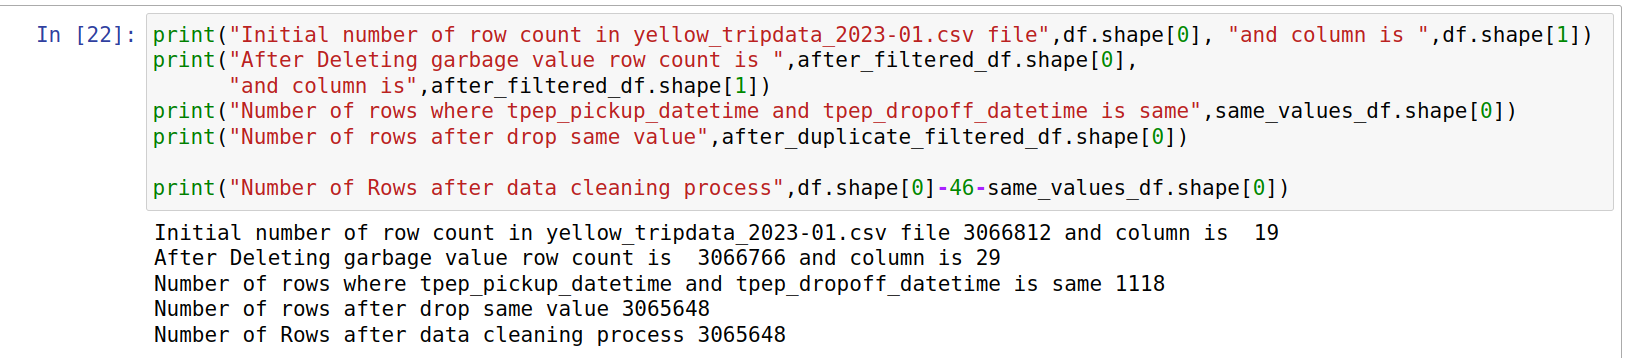

In [43]:
from IPython import display
display.Image("/home/bibek/Desktop/uber_data_engineering/pictures/5.png")

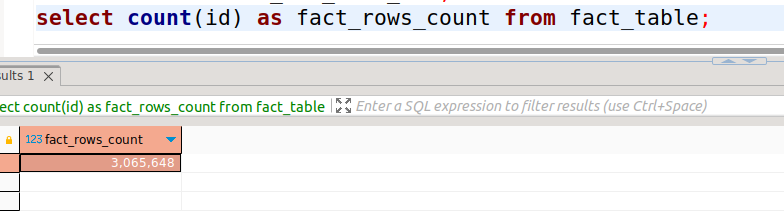

In [44]:
from IPython import display
display.Image("/home/bibek/Desktop/uber_data_engineering/pictures/4.png")

#### Number of records is same i.e. 3065648 and that's the number of records have to inserted in fact table